In [ ]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [2]:
# import libraries 

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# the other plotting library is seaborn - we'll use both during the class

import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

import statsmodels.formula.api as smf # basic statistical modeling

from scipy.stats.stats import pearsonr 

import os

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean
from scipy.stats import ttest_ind

import random

from pandas.tools.plotting import scatter_matrix



In [3]:
# define a default figure size so we don't have to keep setting it

plt.rcParams['figure.figsize'] = [4.0,4.0]

In [4]:
# load dataframe with expression data

datafile = "data/barton/Barton_combined_Ygenes.txt"
df = pd.read_csv(datafile, sep='\t')   # the sep='\t' tells pandas that it is a tab separated file

df = df.set_index('Gene')

df.head()

,Snf2_rep01,Snf2_rep02,Snf2_rep03,Snf2_rep04,Snf2_rep05,Snf2_rep06,Snf2_rep07,Snf2_rep08,Snf2_rep09,Snf2_rep10,...,WT_rep39,WT_rep40,WT_rep41,WT_rep42,WT_rep43,WT_rep44,WT_rep45,WT_rep46,WT_rep47,WT_rep48
Gene,,,,,,,,,,,,,,,,,,,,,
YAL001C,840,653,823,1036,510,820,1240,549,828,738,...,353,696,492,445,419,289,541,292,647,409
YAL002W,712,530,607,771,395,605,904,351,589,533,...,356,756,552,440,389,291,552,346,622,453
YAL003W,7296,6129,6464,7278,5613,3046,7687,6714,8382,7678,...,9291,12055,13542,8441,7337,8639,14315,6618,14745,9878
YAL004W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL005C,9851,10226,12006,10714,8575,2791,11764,8237,12213,12446,...,10177,21176,13270,12337,14303,14268,14993,9607,16075,14797


In [5]:
# you will likely want to use lists of experiments 

# first we create a dictionary that will allow us to keep different types
# of experiment lists together

exps = {}


# now we create a list which we call 'all' containing all of the columns (sample names)

exps['all'] = [e for e in df.columns.get_values()]

# then create lists with just WT and Snf2 mutants

# the syntax here in English is 
# [] create a new list
# [e for e in exps] fills the list with all values from the list exps
# if e.startswith('WT') filters the list to only include elements that start with 'WT'


exps['wt'] = [e for e in exps['all'] if e.startswith('WT')] 

exps['mut'] = [e for e in exps['all'] if e.startswith('Snf2')] 

In [6]:
# filter out samples with average correlation < .95


# create new lists of filtered experiments

exps_filt = {}

# this creates an empty list called 'all'

exps_filt['all'] = []

corrcutoff = .95 

# now we loop over the two types of samples -- wt and mut

for stype in ['wt','mut']:
    
    exps_filt[stype] = []
    
    # loop over all of the sample in that experiment type
    for i1,e1 in enumerate(exps[stype]):
        
        # for each sample create an empty list of its correlations
        corrs = []
        
        # now loop over the samples to compare it to
        for i2,e2 in enumerate(exps[stype]):
            
            # make sure you don't compare it to itself
            if i1 != i2:
                
                # calculate the correlation
                corr = pearsonr(df[e1],df[e2])
                
                # the function returns two values, correlation and p-value
                # we care about correlation which we access as corr[0]
                # and we append it to the list of correlations
                
                corrs.append(corr[0])
        
        # if the mean correlation is greater than our cutoff it's a good sample
        # add it to the list of filtered experiments both all and stype specific 
        
        if np.mean(corrs) > corrcutoff:
            exps_filt['all'].append(e1)
            exps_filt[stype].append(e1)
        

In [7]:
#
# normalize all to geometric mean 
# repeat 3x 
#

for repeats in range(0,3):
    
    df['Gmean'] = gmean(df.loc[:,exps['all']],axis=1)

    #
    # then calculate a normalization factor for each sample
    #

    for c in exps['all']:
        colnorm = np.median((df[c]/df['Gmean']).replace([np.inf, -np.inf], np.nan).dropna())
        df[c] = df[c] / colnorm


In [8]:
# first create new columns that are averages over all data and sample types

df['ave_wt'] = df[exps_filt['wt']].mean(axis=1)
df['ave_mut'] = df[exps_filt['mut']].mean(axis=1)
df['ave'] = df[exps_filt['wt'] + exps_filt['mut']].mean(axis=1)

In [9]:
# medians

df['med_wt'] = df[exps_filt['wt']].median(axis=1)
df['med_mut'] = df[exps_filt['mut']].median(axis=1)
df['med'] = df[exps_filt['wt'] + exps_filt['mut']].median(axis=1)

In [10]:
# variance

df['var_wt'] = df[exps_filt['wt']].var(axis=1)
df['var_mut'] = df[exps_filt['mut']].var(axis=1)
df['var'] = df[exps_filt['wt'] + exps_filt['mut']].var(axis=1)

In [11]:
# std

df['std_wt'] = df[exps_filt['wt']].std(axis=1)
df['std_mut'] = df[exps_filt['mut']].std(axis=1)
df['std'] = df[exps_filt['wt'] + exps_filt['mut']].std(axis=1)

So now, how do we identify outliers? Many people start by saying genes up or down 2x. So let's look at those.

In [12]:
# lets make a function to plot differentially expressed genes

def plot_de(df,c1,c2):
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    maxval = np.max(np.append(df[c1].values,df[c1].values))
    ax.set_xlim(1,maxval)
    ax.set_ylim(1,maxval)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("WT")
    ax.set_ylabel("Mutant")

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c1]/df[c2] > 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='green',label='down 2x (n = %d)' % len(ldf))

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c2]/df[c1] > 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='red',label='up 2x (n = %d)' % len(ldf))

    plt.legend()

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c2]/df[c1] < 2.0) & (df[c1]/df[c2] < 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='black',alpha = .25)

    x = np.linspace(1,maxval,1000)
    ax.plot(x,x,'b-')


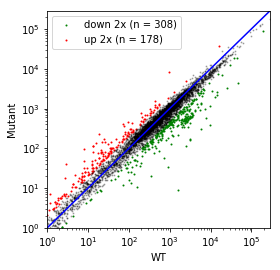

In [13]:
plot_de(df,'ave_wt','ave_mut')

Let's start our exploration of how many experiments we need by looking at the fold-change. We'll assume that the ratio of the average WT and MUT across all samples is the "true" answer and look at how it changes with different sample sizes.

Our goal is to look at a range of sample sizes, and do a bunch of trials where we randomly select samples from WT and MUT and see what the average WT/MUT ratio is in these smaller samples compared to the "true" answer.

In [14]:
df['averat'] = df['ave_mut']/df['ave_wt']

In [15]:
# we'll do this in a copy of the original dataframe so that we can delete it 
# after each sample without losing the original data

In [16]:
df2 = df.copy()

In [17]:
n = 2

ss_wt = random.sample(exps_filt['wt'], n)
ss_mut = random.sample(exps_filt['mut'], n)

print (ss_wt)
print (ss_mut)

['WT_rep34', 'WT_rep16']
['Snf2_rep30', 'Snf2_rep02']


In [18]:
n = 2

ss_wt = random.sample(exps_filt['wt'], n)
ss_mut = random.sample(exps_filt['mut'], n)

df2['averat_ss'] = df2[ss_mut].mean(axis=1).values/df2[ss_wt].mean(axis=1).values

Text(0, 0.5, 'Subsample ratio')

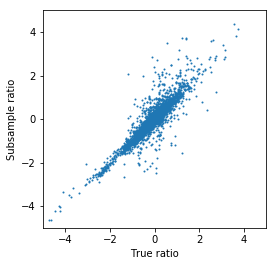

In [19]:
# columns to plot

c1 = "averat"
c2 = "averat_ss"

# create a filtered view of dataframe that gets rid of rows with 0's, inf and nan
dfplot = df2[[c1,c2]][(df2[c1] > 0) & (df2[c2] > 0)].replace(([np.inf, -np.inf], np.nan)).dropna()

# take log base 2 
x = np.log2(dfplot[c1])
y = np.log2(dfplot[c2])

# plot

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x,y,s=1)

ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_xlabel("True ratio")
ax.set_ylabel("Subsample ratio")

Text(0, 0.5, 'Subsample ratio')

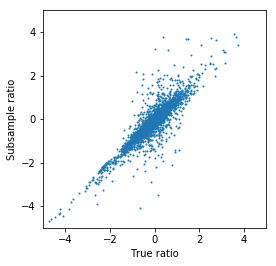

In [20]:
df2 = df.copy()

n = 2

ss_wt = random.sample(exps_filt['wt'], n)
ss_mut = random.sample(exps_filt['mut'], n)

df2['averat_ss'] = df2[ss_mut].mean(axis=1).values/df2[ss_wt].mean(axis=1).values

# columns to plot

c1 = "averat"
c2 = "averat_ss"

# create a filtered view of dataframe that gets rid of rows with 0's, inf and nan
dfplot = df2[[c1,c2]][(df2[c1] > 0) & (df2[c2] > 0)].replace(([np.inf, -np.inf], np.nan)).dropna()

# take log base 2 
x = np.log2(dfplot[c1])
y = np.log2(dfplot[c2])

# plot

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x,y,s=1)

ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_xlabel("True ratio")
ax.set_ylabel("Subsample ratio")


Text(0, 0.5, 'Subsample ratio')

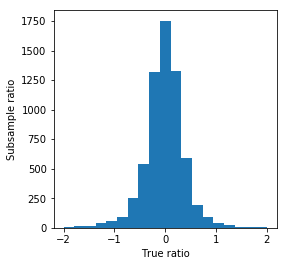

In [21]:
# what is the distribution of errors

df2 = df.copy()

n = 2

ss_wt = random.sample(exps_filt['wt'], n)
ss_mut = random.sample(exps_filt['mut'], n)

df2['averat_ss'] = df2[ss_mut].mean(axis=1).values/df2[ss_wt].mean(axis=1).values

c1 = "averat"
c2 = "averat_ss"

dfplot = df2[[c1,c2]][(df2[c1] > 0) & (df2[c2] > 0)].replace([np.inf, -np.inf], np.nan).dropna()

# take log base 2 
x = np.log2(dfplot[c1])
y = np.log2(dfplot[c2])

# plot

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(y-x,bins=np.linspace(-2,2,20))
ax.set_xlabel("True ratio")
ax.set_ylabel("Subsample ratio")


(-4, 4)

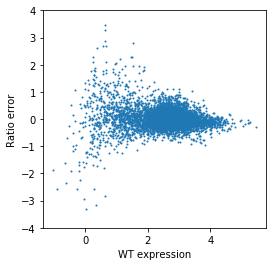

In [22]:

df2 = df.copy()

n = 2

ss_wt = random.sample(exps_filt['wt'], n)
ss_mut = random.sample(exps_filt['mut'], n)

df2['averat_ss'] = df2[ss_mut].mean(axis=1).values/df2[ss_wt].mean(axis=1).values

c1 = "averat"
c2 = "averat_ss"

df2['rat_err'] = np.log2(df2[c2]) - np.log2(df2[c1])

x = np.log10(df2['ave_wt'])
y = df2['rat_err']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x,y, s= 1)
ax.set_xlabel("WT expression")
ax.set_ylabel("Ratio error")
ax.set_ylim(-4,4)


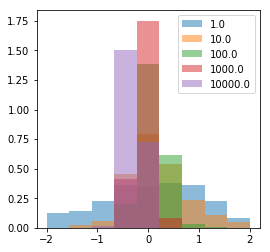

In [23]:
# what is the distribution of errors

df2 = df.copy()

n = 2

ss_wt = random.sample(exps_filt['wt'], n)
ss_mut = random.sample(exps_filt['mut'], n)

df2['averat_ss'] = df2[ss_mut].mean(axis=1).values/df2[ss_wt].mean(axis=1).values

c1 = "averat"
c2 = "averat_ss"


fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for e in np.linspace(0,4,5):
    dfplot = df2[[c1,c2]][(df2[c1] > 0) & (df2[c2] > 0) & (df2['ave_wt'].between(10**e,10**(e+.5)))].replace([np.inf, -np.inf], np.nan).dropna()
    x = np.log2(dfplot[c1])
    y = np.log2(dfplot[c2])
    
    ax.hist(y-x,bins=np.linspace(-2,2,10),density=True,label="%s"%10**e,alpha=.5)
    
plt.legend()
    


From this kind of analysis one can derive a reasonable sense of what the likely error is ratios as a function of sample size and expression level. But it's difficult to classify the answer as right or wrong. So lets try something where we can do this.

In [24]:
ttestp = []

for index, row in df.iterrows():
    mut = row[exps_filt['mut']]
    wt = row[exps_filt['wt']]
    ttestp.append(ttest_ind(np.log(wt),np.log(mut))[1])
    
df['ttestp'] = ttestp

Text(0.5, 0, 't-test pvalue')

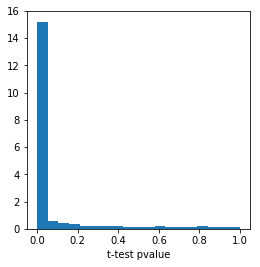

In [25]:
h = plt.hist(df.ttestp,density=True,bins=np.linspace(0,1,20))
plt.xlabel("t-test pvalue")

Text(0.5, 0, '-log10 t-test pvalue')

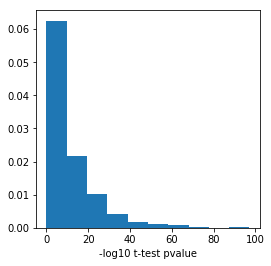

In [26]:
h = plt.hist(-np.log10(df.ttestp),density=True)
plt.xlabel("-log10 t-test pvalue")

In [27]:
# how does this change with sample size?

In [28]:
df2 = df.copy()

sample_sizes = [2,3,4,5,6,7,8,9,10,15,20,40]
trials = 1

for ss in sample_sizes:
    for t in range(0,trials):
        ss_wt = random.sample(exps_filt['wt'], ss)
        ss_mut = random.sample(exps_filt['mut'], ss)
        
        ttestp = []

        for index, row in df2.iterrows():
            mut = row[ss_mut]
            wt = row[ss_wt]
            ttestp.append(ttest_ind(np.log10(wt),np.log10(mut))[1])
    
        df2['ttestp_ss%d_t%d' % (ss,t)] = ttestp

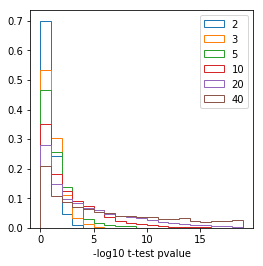

In [29]:
sample_sizes = [2,3,5,10,20,40]

for ss in sample_sizes:

    h = plt.hist(-np.log10(df2['ttestp_ss%d_t0' % ss]),density=True, histtype='step',label="%d" %ss,bins=range(0,20))
    
plt.xlabel("-log10 t-test pvalue")

plt.legend()

In [30]:
# what fraction are "significant"?

sigcutoff = -np.log10(.05)

bc_sigcutoff = -np.log10(.05 / len(df))

for ss in sample_sizes:
    sig = len(df2[-np.log10(df2['ttestp_ss%d_t0' % ss]) > sigcutoff])
    bc_sig = len(df2[-np.log10(df2['ttestp_ss%d_t0' % ss]) > bc_sigcutoff])
    print ("%3d %5d %.3f %5d %.3f" %(ss,sig,sig/len(df),bc_sig,bc_sig/len(df)))

  2  1156 0.173     1 0.000
  3  2223 0.333    22 0.003
  5  2724 0.407   212 0.032
 10  3612 0.540  1029 0.154
 20  4157 0.622  2058 0.308
 40  4838 0.724  3306 0.495


Text(0, 0.5, 'Subsample p-value')

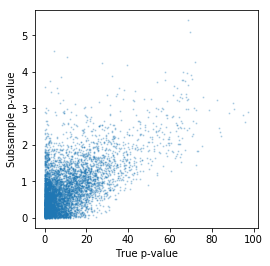

In [31]:


c1 = "ttestp"
c2 = "ttestp_ss2_t0"

# create a filtered view of dataframe that gets rid of rows with 0's, inf and nan

x = -np.log10(df2[c1])
y = -np.log10(df2[c2])

# plot

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x,y,s=1,alpha=.25)

#ax.set_xlim(-5,5)
#ax.set_ylim(-5,5)
ax.set_xlabel("True p-value")
ax.set_ylabel("Subsample p-value")


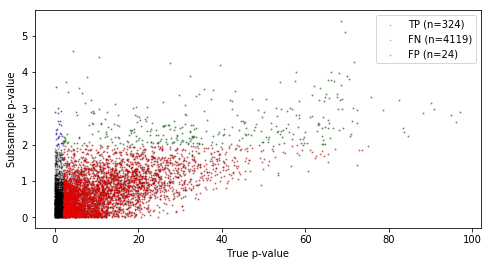

In [32]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

c1 = "ttestp"
c2 = "ttestp_ss2_t0"

sigcut = .01

# create a filtered view of dataframe that gets rid of rows with 0's, inf and nan

x = -np.log10(df2[c1])
y = -np.log10(df2[c2])

# plot

ax.scatter(x,y,s=1,c='black',alpha=.25, label="")

#ax.set_xlim(-5,5)
#ax.set_ylim(-5,5)
ax.set_xlabel("True p-value")
ax.set_ylabel("Subsample p-value")

df3 = df2[(df2[c1] < sigcut) & (df2[c2] < sigcut)]
x = -np.log10(df3[c1])
y = -np.log10(df3[c2])
ax.scatter(x,y,s=1,c='green',alpha=.25,label="TP (n=%d)" % len(x))

df3 = df2[(df2[c1] < sigcut) & (df2[c2] > sigcut)]
x = -np.log10(df3[c1])
y = -np.log10(df3[c2])
ax.scatter(x,y,s=1,c='red',alpha=.25,label="FN (n=%d)" % len(x))

df3 = df2[(df2[c1] > sigcut) & (df2[c2] < sigcut)]
x = -np.log10(df3[c1])
y = -np.log10(df3[c2])
ax.scatter(x,y,s=1,c='blue',alpha=.25,label="FP (n=%d)" % len(x))


plt.legend()

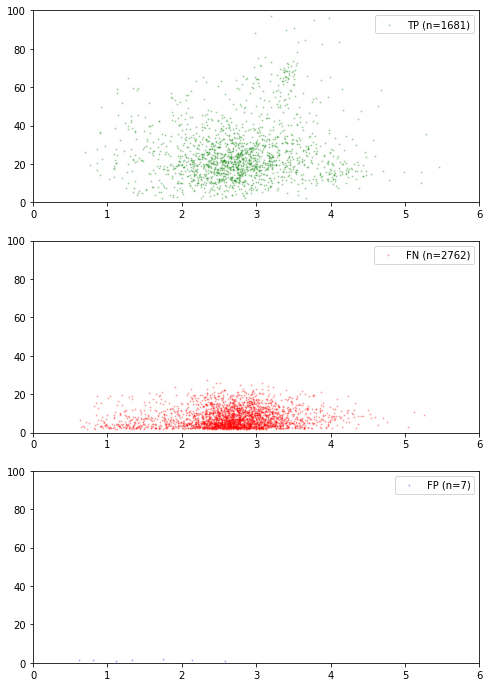

In [33]:
fig = plt.figure(figsize=(8,12))

c1 = "ttestp"
c2 = "ttestp_ss5_t0"
c3 = "ave_wt"

sigcut = .01


ax = fig.add_subplot(3,1,1)
df3 = df2[(df2[c1] < sigcut) & (df2[c2] < sigcut)]
x = np.log10(df3[c3])
y = -np.log10(df3[c1])
ax.scatter(x,y,s=1,c='green',alpha=.25,label="TP (n=%d)" % len(x))
ax.set_xlim(0,6)
ax.set_ylim(0,100)
ax.legend()

ax = fig.add_subplot(3,1,2)
df3 = df2[(df2[c1] < sigcut) & (df2[c2] > sigcut)]
x = np.log10(df3[c3])
y = -np.log10(df3[c1])
ax.scatter(x,y,s=1,c='red',alpha=.25,label="FN (n=%d)" % len(x))
ax.set_xlim(0,6)
ax.set_ylim(0,100)
ax.legend()

ax = fig.add_subplot(3,1,3)
df3 = df2[(df2[c1] > sigcut) & (df2[c2] < sigcut)]
x = np.log10(df3[c3])
y = -np.log10(df3[c1])
ax.scatter(x,y,s=1,c='blue',alpha=.25,label="FP (n=%d)" % len(x))
ax.set_xlim(0,6)
ax.set_ylim(0,100)
ax.legend()



How does the power of these tests vary as we change the sample size?

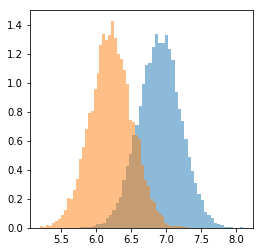

In [34]:
#
# generate some synthetic data
#

foldchange = 0.5


replicates = 10000
m1 = 1000
m2 = foldchange * m1
v = .3

wt = np.random.lognormal(np.log(m1),v,replicates)
mut = np.random.lognormal(np.log(m2),v,replicates)

x = plt.hist(np.log(wt),bins=50,alpha=0.5,density=True)
x = plt.hist(np.log(mut),bins=50,alpha=0.5,density=True)



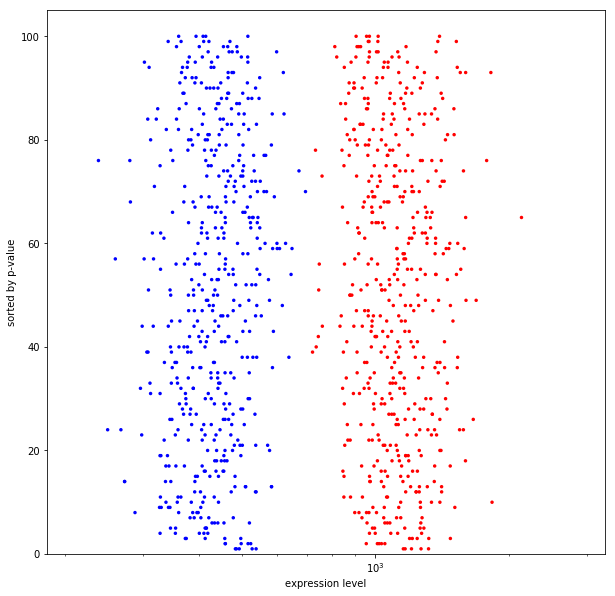

In [35]:
sample_size = 5
trials = 10000

data = []
alldata = []
for t in range(0,trials):
    wtr = np.random.choice(wt,sample_size)
    mutr = np.random.choice(mut,sample_size)
    data.append([ttest_ind(np.log(wtr),np.log(mutr))[1],wtr,mutr])
    alldata.extend(wtr)
    alldata.extend(mut)
    
datas = sorted(data,key = lambda x: x[0],reverse=False)

x1 = []
x2 = []
y = []

datap = datas[0:100]
for i,d in enumerate(datap[0:100]):
    x1.extend(d[1])
    x2.extend(d[2])
    y.extend([i+1] * sample_size)
    
fig = plt.figure(figsize = (10,.1*len(datap)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(min(alldata),max(alldata))
ax.set_ylim(0,max(y)+5)
ax.set_xscale("log", nonposx='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("sorted by p-value")
ax.scatter(x1,y,s=12,c='r',edgecolor='none')
ax.scatter(x2,y,s=12,c='b',edgecolor='none')

In [36]:

#
# lets look at the effect of changing the number of experiments we did
#

pvals = {}

trials = 1000

sample_sizes = [2,3,4,5,6,7,8,9,10,15,20]
for n in sample_sizes:
    pvals[n] = []
    for t in range(0,trials):
        wtr = np.random.choice(wt,n)
        mutr = np.random.choice(mut,n)
        #pvals[n].append(-np.log10(ks_2samp(wtr,mutr)[1]))
        pvals[n].append(-np.log10(ttest_ind(np.log(wtr),np.log(mutr))[1]))
    

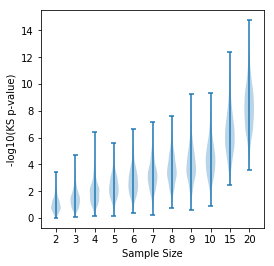

In [37]:
fig, ax = plt.subplots()

ax.violinplot(dataset = [pvals[v] for v in sample_sizes])
ax.set_title('')
ax.yaxis.grid(False)
ax.set_xlabel('Sample Size')
ax.set_ylabel('-log10(KS p-value)')
a = plt.xticks(range(1,len(sample_sizes)+1),sample_sizes)

Text(0.5, 1.0, 'Distribution of p-values for different sample sizes')

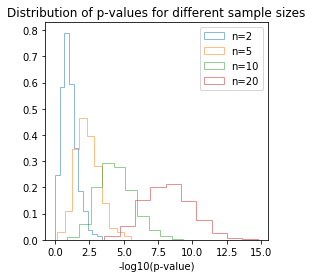

In [38]:
for v in [2,5,10,20]:
    plt.hist(pvals[v],alpha=.5,label='n=%d' %v, histtype='step', density=True)

plt.legend()
plt.xlabel("-log10(p-value)")
plt.title("Distribution of p-values for different sample sizes")

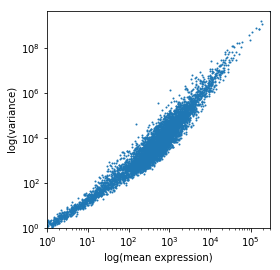

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1,300000)
ax.set_ylim(1,np.max(df.var_wt))
ax.set_xlabel("log(mean expression)")
ax.set_ylabel("log(variance)")
ax.scatter(df.ave_wt,df.var_wt,s=1)

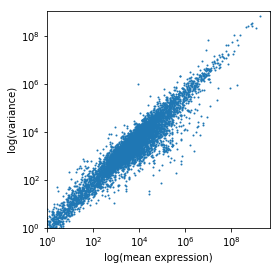

In [40]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1,np.max(df.var_wt))
ax.set_ylim(1,np.max(df.var_mut))
ax.set_xlabel("log(mean expression)")
ax.set_ylabel("log(variance)")
ax.scatter(df.var_wt,df.var_mut,s=1)

In [41]:
# how does downsampling affect estimate of variance

mus = []
stds = []

cols = random.sample(exps_filt['wt'],2)

for i,r in df.iterrows():
    mu, std = norm.fit(r[cols])
    mus.append(mu)
    stds.append(std*std)
    
df['wtfitmu'] = mus
df['wtfitvars'] = stds


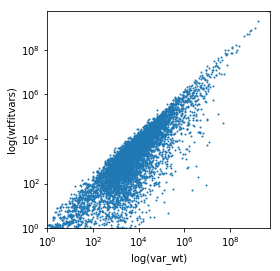

In [43]:
c1 = "var_wt"
c2 = "wtfitvars"

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log")
ax.set_yscale("log")
maxval = np.max(np.concatenate((df[c1].values,df[c2].values)))
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xlabel("log(%s)" % c1)
ax.set_ylabel("log(%s)" % c2)
ax.scatter(df[c1],df[c2],s=1)

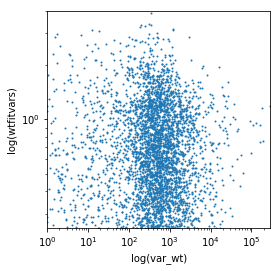

In [44]:
x = df['ave_wt']
y = df['wtfitvars']/df['var_wt']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1,np.max(x))
ax.set_ylim(.25,4)
ax.set_xlabel("log(%s)" % c1)
ax.set_ylabel("log(%s)" % c2)
ax.scatter(x,y,s=1)

(array([   2.,    0.,    2.,    4.,    5.,    5.,    5.,   16.,   28.,
          34.,   82.,  124.,  185.,  275.,  415.,  740., 1193., 1819.,
        1376.,  116.]),
 array([-23.77609648, -22.47159557, -21.16709466, -19.86259375,
        -18.55809284, -17.25359193, -15.94909102, -14.64459011,
        -13.3400892 , -12.03558829, -10.73108738,  -9.42658647,
         -8.12208556,  -6.81758465,  -5.51308374,  -4.20858283,
         -2.90408192,  -1.59958101,  -0.2950801 ,   1.00942081,
          2.31392172]),
 <a list of 20 Patch objects>)

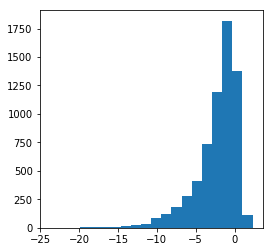

In [45]:
plt.hist(np.log2([yy for yy in y if yy > 0]),bins=20)

In [46]:
df['effsize'] = np.abs(df['ave_mut'] - df['ave_wt'])/df['std']

Text(0, 0.5, 'density')

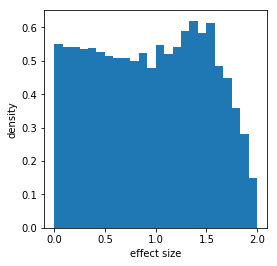

In [47]:
plt.hist(df['effsize'], bins=np.linspace(0,2,25),density=True)
plt.xlabel("effect size")
plt.ylabel("density")

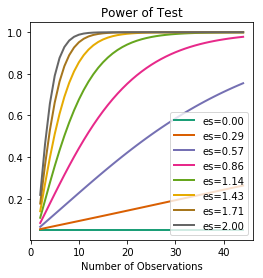

In [48]:
from statsmodels.stats.power import TTestIndPower

pa = TTestIndPower()

a = pa.plot_power(dep_var='nobs', nobs=np.arange(2,45), effect_size=np.linspace(0,2,8))